In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('stroke_data.csv')
print(df.head())
df = df.dropna()

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
target_col = 'stroke'

cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'avg_glucose_level', 'bmi']
feature_cols = cat_cols + num_cols

# bmi спорный критерий 

Проверим на выбросы 
Sales - ok
CPI - ok
Temperature - idk. Is 100 tem ok ?
Fuel_Price - ok
Unemployment - ok 

In [8]:
traget_blowout_col = 'age'
sorted_df = df.sort_values(by= traget_blowout_col)
print(sorted_df[traget_blowout_col].head(15))
#print(sorted_df[traget_blowout_col].tail(15))
# есть люди с возрастом меньше 1, думаю есть смысл рассматривать ток 25+

3295    0.08
1614    0.08
3968    0.16
3618    0.16
4021    0.16
4293    0.24
3392    0.24
996     0.24
1999    0.24
2898    0.24
564     0.32
3859    0.32
2579    0.32
1093    0.32
4910    0.32
Name: age, dtype: float64


In [9]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_10236\3784545759.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.008984,0.001147,0.004016,0.006409,0.003084,0.004839
age,0.008984,1.000000,0.274425,0.257123,0.235838,0.333398,0.232331
hypertension,0.001147,0.274425,1.000000,0.115991,0.180543,0.167811,0.142515
heart_disease,0.004016,0.257123,0.115991,1.000000,0.154525,0.041357,0.137938
avg_glucose_level,0.006409,0.235838,0.180543,0.154525,1.000000,0.175502,0.138936
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.004839,0.232331,0.142515,0.137938,0.138936,0.042374,1.000000


# Remove children

In [12]:
df = df.query('age >= 25')

# divide on train and validation

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score,  roc_curve

In [15]:
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Начну со своей реализации

In [16]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [17]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- матрица объекты-признаки
    param y: np.array[n_objects] --- вектор целевых переменных
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    batch_num = int(len(X)/ batch_size)
    batch_start = 0
    for i in range(batch_num):
        #YOUR CODE
        batch_indexes = perm[batch_start: batch_start + batch_size]
        yield X[batch_indexes], y[batch_indexes]
        batch_start += batch_size

In [18]:
class MyLogisticRegression(object):
    def __init__(self, epochs=10, lr=0.1, batch_size=100):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size

    def fit(self, X, y):
        n, k = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)

        losses = []


        for i in range(self.epochs):
            for X_batch, y_batch in generate_batches(X_train, y, self.batch_size):
                #В X_train уже добавлен вектор 1

                predictions = sigmoid(logit(X_batch, self.w))
                loss = self.__loss(y_batch, predictions)

                assert (np.array(loss).shape == tuple()), "Лосс должен быть скаляром!"

                losses.append(loss)

                self.w = self.w - self.lr * self.get_grad(X_batch, y_batch, predictions)
    
        return losses

    def get_grad(self, X_batch, y_batch, predictions):

        grad_basic = X_batch.T @ (predictions - y_batch)
        assert grad_basic.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic

    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X):
        """
        Возможно, вы захотите использовать эту функцию вместо predict_proba, поскольку
        predict_proba конкатенирует вход с вектором из единиц, что не всегда удобно
        для внутренней логики вашей программы
        """
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w.copy()

    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def set_params(self, **params):
        # Устанавливает значения параметров модели
        self.lr = params.get('lr', self.lr)
        self.epochs = params.get('epochs', self.epochs)
        self.batch_size = params.get('batch_size', self.batch_size)

    def get_params(self, deep=True):
        # Возвращает словарь параметров модели
        return {
            'lr': self.lr,
            'epochs': self.epochs,
            'batch_size': self.batch_size
        }

In [22]:
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Объединение преобразований для категориальных и числовых колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ])



# Создание pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', MyLogisticRegression())     
])

In [26]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict_proba(X_test)
print('test: ',roc_auc_score(y_test, y_pred))

y_pred = pipeline.predict_proba(X_train)
print('train: ',roc_auc_score(y_train, y_pred))

test:  0.8147350473370126
train:  0.7911397332528842


# Sklearn Linear Regression

In [27]:
def draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted):
    train_auc = roc_auc_score(y_train, y_train_predicted)
    test_auc = roc_auc_score(y_test, y_test_predicted)

    plt.figure(figsize=(10,7))
    plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

In [28]:
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Объединение преобразований для категориальных и числовых колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('num', numerical_transformer, num_cols)
    ])



# Создание pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', LogisticRegression())     
])

In [29]:
parameters = {
    'classifier__C': [0.01, 0.1, 0.2, 0.3, 0.4],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']#, 'saga']
}
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='roc_auc')

In [30]:
grid_search.fit(X_train, y_train)

# Вывод результатов GridSearchCV
print("Лучшие параметры: ", grid_search.best_params_)
print("Наилучший результат кросс-валидации (AUC-ROC): ", grid_search.best_score_)

# Оценка модели на тестовом наборе
auc_roc = grid_search.score(X_test, y_test)
print("AUC-ROC на тестовом наборе: ", auc_roc)

Лучшие параметры:  {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Наилучший результат кросс-валидации (AUC-ROC):  0.7908971243036993
AUC-ROC на тестовом наборе:  0.8199174406604748


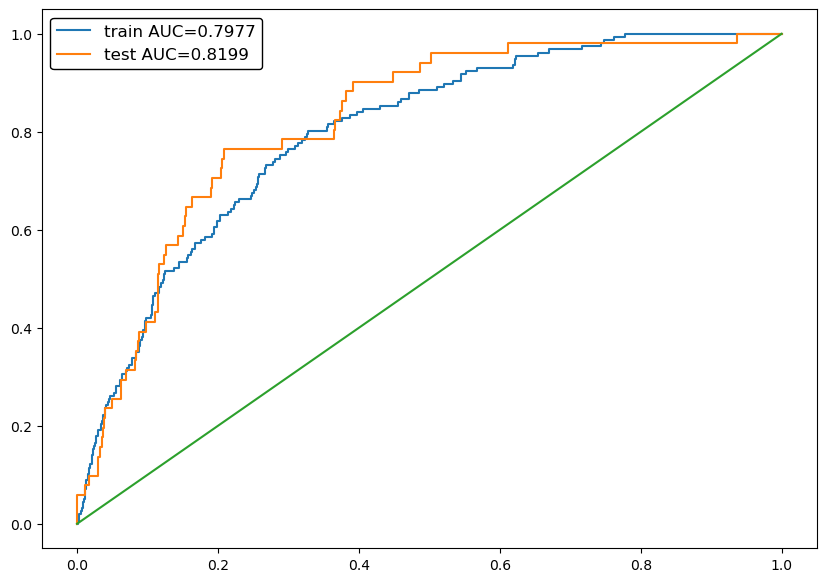

In [31]:
y_test_predicted = grid_search.predict_proba(X_test)[:, 1]
y_train_predicted = grid_search.predict_proba(X_train)[:, 1]
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted) 

# Теперь воспользуемся catboost
(мне он понравился, простой и мощный)

In [32]:
import catboost

In [33]:
X = df[feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC')

params_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.01],
    'depth': [4, 6, 8],
    'l2_leaf_reg': np.linspace(0, 1, 20)
}

boosting_model.grid_search(params_grid, 
                           X_train, 
                           y_train, plot=False, refit=True)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]


bestTest = 0.823961039
bestIteration = 14

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8239610	best: 0.8239610 (0)	total: 3.52s	remaining: 17m 33s

bestTest = 0.8338095238
bestIteration = 11

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8338095	best: 0.8338095 (1)	total: 6.83s	remaining: 16m 57s

bestTest = 0.8055411255
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8055411	best: 0.8338095 (1)	total: 10.2s	remaining: 16m 48s

bestTest = 0.7861688312
bestIteration = 1

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.7861688	best: 0.8338095 (1)	total: 13.5s	remaining: 16m 42s

b

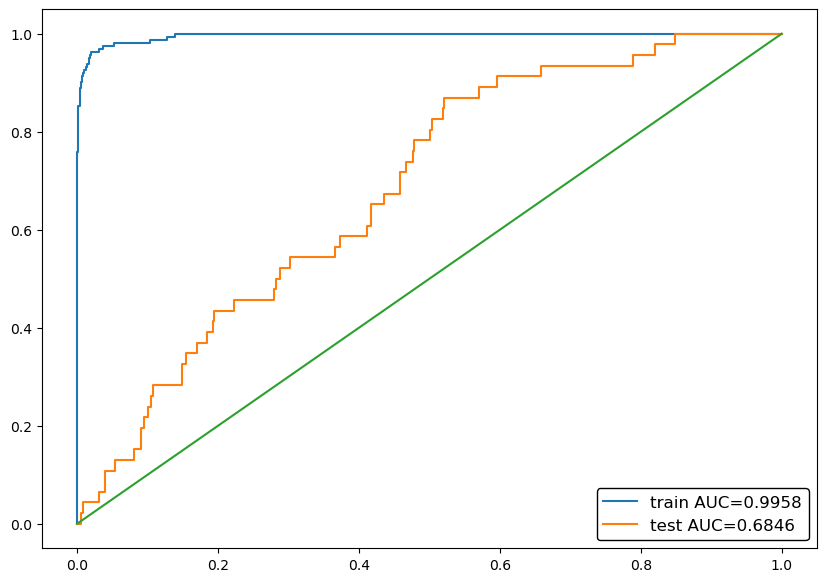

In [35]:
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted)

Overfitting?

# DecisionTreeRegressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
pipeline_DT = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', DecisionTreeRegressor())     
])

In [38]:
parameters = {
    'classifier__max_depth': [None, 5, 8, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(pipeline_DT, param_grid=parameters, cv=5, scoring='roc_auc')

In [39]:
grid_search.fit(X_train, y_train)

# Вывод результатов GridSearchCV
print("Лучшие параметры: ", grid_search.best_params_)
print("Наилучший результат кросс-валидации (AUC-ROC): ", grid_search.best_score_)

# Оценка модели на тестовом наборе
auc_roc = grid_search.score(X_test, y_test)
print("AUC-ROC на тестовом наборе: ", auc_roc)

Лучшие параметры:  {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Наилучший результат кросс-валидации (AUC-ROC):  0.7390333468980439
AUC-ROC на тестовом наборе:  0.7135070793133692


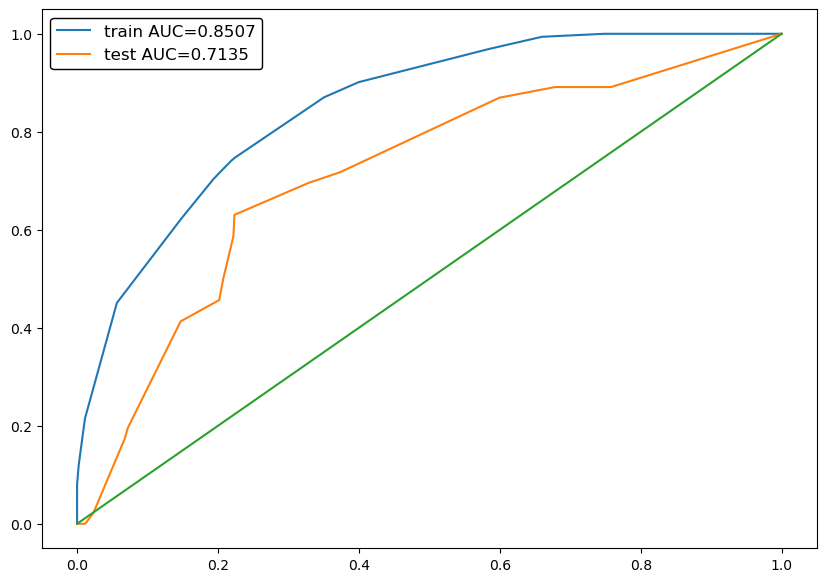

In [40]:
y_test_predicted = grid_search.predict(X_test)#[:, 1]
y_train_predicted = grid_search.predict(X_train)#[:, 1]
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted) 

# SVM
(как я понимаю это только для оинейно разделимых случаев*)
*можно сделать фичи нелинейными

In [41]:
from sklearn.svm import SVC

In [42]:
pipeline_SVM = Pipeline([
    ('preprocessor', preprocessor),          
    ('classifier', SVC())     
])
parameters = {
    'classifier__C': [0.1, 0.2, 0.3, 0.4, 1, 10],
}
grid_search = GridSearchCV(pipeline_SVM, param_grid=parameters, cv=5, scoring='roc_auc')

In [43]:
grid_search.fit(X_train, y_train)

# Вывод результатов GridSearchCV
print("Лучшие параметры: ", grid_search.best_params_)
print("Наилучший результат кросс-валидации (AUC-ROC): ", grid_search.best_score_)

# Оценка модели на тестовом наборе
auc_roc = grid_search.score(X_test, y_test)
print("AUC-ROC на тестовом наборе: ", auc_roc)

Лучшие параметры:  {'classifier__C': 10}
Наилучший результат кросс-валидации (AUC-ROC):  0.5744701325805976
AUC-ROC на тестовом наборе:  0.6146786117027941


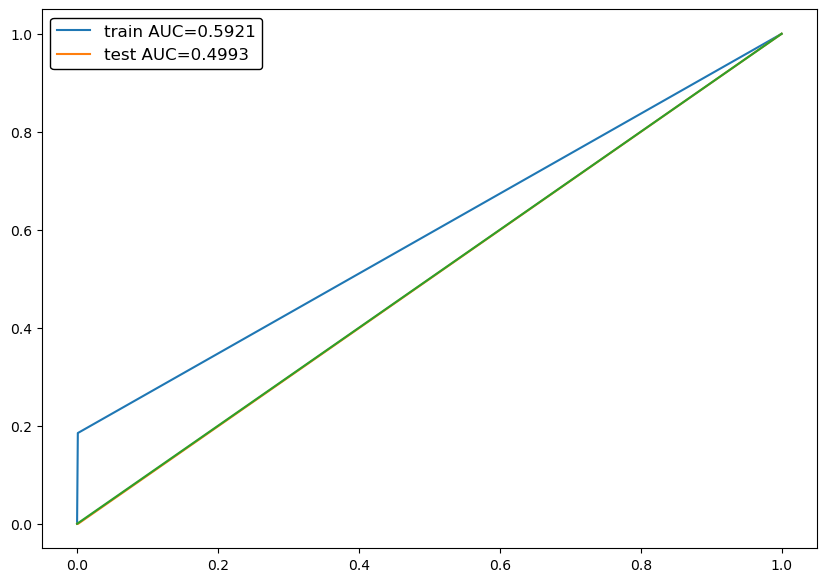

In [44]:
y_test_predicted = grid_search.predict(X_test)#[:, 1]
y_train_predicted = grid_search.predict(X_train)#[:, 1]
draw_auc_curve(y_train, y_train_predicted, y_test, y_test_predicted) 